# NCI GDC Data Analysis

Datasets were pulled from https://portal.gdc.cancer.gov/analysis_page?app=CohortBuilder&tab=general_diagnosis 
They were filtered for Breast Cancer before pulled. Need to check with Arjita on the exact process of that

## Load Packages

In [787]:
import pandas as pd
import plotly.express as px
import numpy as np
import requests
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt


pd.set_option('future.no_silent_downcasting', True)

## Import Data from Github

Pull in gene dataset. 

In [790]:
response = requests.get('https://raw.githubusercontent.com/aaditya0106/cancer-dashboard/main/Data/HierCluster.2024-11-19.tsv')
if response.status_code == 200:
    gene = pd.read_csv(StringIO(response.text), sep='\t')
    print("Data loaded successfully!")
else:
    print(f"Failed to fetch data: {response.status_code}")

Data loaded successfully!


Pull in clinical dataset.

In [792]:
response = requests.get('https://raw.githubusercontent.com/aaditya0106/cancer-dashboard/main/Data/clinical.tsv')
if response.status_code == 200:
    clinical = pd.read_csv(StringIO(response.text), sep='\t')
    print("Data loaded successfully!")
else:
    print(f"Failed to fetch data: {response.status_code}")

Data loaded successfully!


## Basic gene data exploration

In [794]:
gene.head()

,Case,ANO1,CTTN,GAB2,TSKU,PEG10,TSPAN12,VSIG2,INHBB,CLU,...,DSG2,PGGHG,MYH14,PTPRU,CEP170B,TRPM4,AGRN,LAMA5,SLC17A9,SMIM24
0,TCGA-AC-A2QJ,-0.850784,-0.067790,-0.373197,0.353471,-0.424534,-0.627105,-0.225790,-0.428333,-0.396251,...,-1.360506,-0.405373,-1.069204,-0.642400,-0.293741,-0.317442,1.454789,-0.886521,2.645691,0.438836
1,TCGA-FA-A7DS,-0.903327,-0.984412,-0.434487,-0.533308,-0.510474,-0.649774,-0.417569,-0.591520,-0.415010,...,-1.479773,-0.243668,-1.159843,-1.038820,-1.792239,2.025728,-1.518411,-0.801080,4.244228,-0.274578
2,TCGA-A2-A4S1,-0.749352,-0.266099,-0.379331,0.198941,-0.155934,-0.530950,-0.325875,-0.373839,-0.306217,...,-1.429917,0.136463,-1.169063,-0.786902,-0.390244,-0.130008,0.732697,-0.683839,0.121208,-0.107634
3,TCGA-AR-A5QQ,0.292535,-0.049525,-0.475821,0.243683,-0.502936,-0.565909,-0.318526,-0.471878,-0.377541,...,-0.485598,-0.440984,-0.992049,-0.228702,-0.046550,-1.026940,1.468554,-0.556163,-0.100514,-0.221282
4,TCGA-E9-A5FL,-0.787100,0.226868,-0.429163,0.435614,-0.384482,-0.507950,0.562074,-0.480450,-0.251577,...,-0.915629,1.068320,-0.543074,-0.115328,0.107458,-0.455221,0.150628,0.788012,-0.333208,1.210650


In [795]:
gene.shape

(1000, 1001)

In [796]:
gene.dtypes

Case        object
ANO1       float64
CTTN       float64
GAB2       float64
TSKU       float64
            ...   
TRPM4      float64
AGRN       float64
LAMA5      float64
SLC17A9    float64
SMIM24     float64
Length: 1001, dtype: object

Determine if any values are Null. There are no null values and there are no duplicate samples. 

In [798]:
gene.isnull().any().value_counts()

False    1001
Name: count, dtype: int64

In [799]:
gene['Case'].duplicated().sum()

0

## Basic clinical data exploration

In [801]:
clinical.head()

,case_id,case_submitter_id,project_id,age_at_index,age_is_obfuscated,cause_of_death,cause_of_death_source,country_of_birth,country_of_residence_at_enrollment,days_to_birth,...,treatment_dose_units,treatment_duration,treatment_effect,treatment_effect_indicator,treatment_frequency,treatment_intent_type,treatment_or_therapy,treatment_outcome,treatment_outcome_duration,treatment_type
0,00016c8f-a0be-4319-9c42-4f3bcd90ac92,AD1602,FM-AD,'--,'--,'--,'--,'--,'--,'--,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--
1,001cef41-ff86-4d3f-a140-a647ac4b10a1,TCGA-E2-A1IU,TCGA-BRCA,60,'--,'--,'--,'--,'--,-22279,...,'--,'--,'--,'--,'--,'--,no,'--,'--,"Radiation Therapy, NOS"
2,001cef41-ff86-4d3f-a140-a647ac4b10a1,TCGA-E2-A1IU,TCGA-BRCA,60,'--,'--,'--,'--,'--,-22279,...,'--,'--,'--,'--,'--,'--,yes,'--,'--,"Pharmaceutical Therapy, NOS"
3,002cdb51-32c0-40be-b92f-60961f091bdf,AD16494,FM-AD,'--,'--,'--,'--,'--,'--,'--,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--
4,0045349c-69d9-4306-a403-c9c1fa836644,TCGA-A1-A0SB,TCGA-BRCA,70,'--,'--,'--,'--,'--,-25833,...,'--,'--,'--,'--,'--,'--,not reported,'--,'--,"Radiation Therapy, NOS"


In [802]:
clinical.columns

Index(['case_id', 'case_submitter_id', 'project_id', 'age_at_index',
       'age_is_obfuscated', 'cause_of_death', 'cause_of_death_source',
       'country_of_birth', 'country_of_residence_at_enrollment',
       'days_to_birth',
       ...
       'treatment_dose_units', 'treatment_duration', 'treatment_effect',
       'treatment_effect_indicator', 'treatment_frequency',
       'treatment_intent_type', 'treatment_or_therapy', 'treatment_outcome',
       'treatment_outcome_duration', 'treatment_type'],
      dtype='object', length=219)

In [803]:
clinical.shape

(5268, 219)

Make sure tissue of origin is breast related. These are the types of tissues currently included. 

In [805]:
# Generate the summary table of what tissue_or_organ_of_origin is
summary_table = clinical['tissue_or_organ_of_origin'].value_counts()

# Display the summary table
print(summary_table)

tissue_or_organ_of_origin
Breast, NOS                       5175
Not Reported                        72
Lower-inner quadrant of breast       6
Upper-inner quadrant of breast       4
Upper-outer quadrant of breast       4
Overlapping lesion of breast         4
Lower-outer quadrant of breast       2
'--                                  1
Name: count, dtype: int64


Remove rows where tissue or organ of origin are Not Reported or '--

In [807]:
clinicalBreast = clinical[~clinical['tissue_or_organ_of_origin'].isin(['Not Reported', "'--"])]

# Check the result
print(clinicalBreast['tissue_or_organ_of_origin'].value_counts())


tissue_or_organ_of_origin
Breast, NOS                       5175
Lower-inner quadrant of breast       6
Upper-inner quadrant of breast       4
Upper-outer quadrant of breast       4
Overlapping lesion of breast         4
Lower-outer quadrant of breast       2
Name: count, dtype: int64


In [808]:
clinicalBreast.head()

,case_id,case_submitter_id,project_id,age_at_index,age_is_obfuscated,cause_of_death,cause_of_death_source,country_of_birth,country_of_residence_at_enrollment,days_to_birth,...,treatment_dose_units,treatment_duration,treatment_effect,treatment_effect_indicator,treatment_frequency,treatment_intent_type,treatment_or_therapy,treatment_outcome,treatment_outcome_duration,treatment_type
0,00016c8f-a0be-4319-9c42-4f3bcd90ac92,AD1602,FM-AD,'--,'--,'--,'--,'--,'--,'--,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--
1,001cef41-ff86-4d3f-a140-a647ac4b10a1,TCGA-E2-A1IU,TCGA-BRCA,60,'--,'--,'--,'--,'--,-22279,...,'--,'--,'--,'--,'--,'--,no,'--,'--,"Radiation Therapy, NOS"
2,001cef41-ff86-4d3f-a140-a647ac4b10a1,TCGA-E2-A1IU,TCGA-BRCA,60,'--,'--,'--,'--,'--,-22279,...,'--,'--,'--,'--,'--,'--,yes,'--,'--,"Pharmaceutical Therapy, NOS"
3,002cdb51-32c0-40be-b92f-60961f091bdf,AD16494,FM-AD,'--,'--,'--,'--,'--,'--,'--,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--
4,0045349c-69d9-4306-a403-c9c1fa836644,TCGA-A1-A0SB,TCGA-BRCA,70,'--,'--,'--,'--,'--,-25833,...,'--,'--,'--,'--,'--,'--,not reported,'--,'--,"Radiation Therapy, NOS"


Check that 73 invalid rows were removed

In [810]:
clinicalBreast.shape

(5195, 219)

Get number of duplicate case_submitter_id numbers. These are patients with multiple rows of data.

In [812]:
clinicalBreast['case_submitter_id'].duplicated().sum()

1148

Get a table of the duplicates

In [814]:
# Identify all rows with duplicates
all_duplicates = clinicalBreast[clinicalBreast['case_submitter_id'].duplicated(keep=False)]

## Merge gene and clinicalBreast

In [816]:
geneClinical = gene.merge(clinicalBreast, left_on='Case', right_on='case_submitter_id', how='inner')

In [817]:
geneClinical.shape

(1854, 1220)

Check results for a duplicate case_submitter_id. We want to make sure each case_submitter_id/case always gets the same gene expression data

In [819]:
geneClinical['case_submitter_id'].duplicated().sum()

855

Get a table of the duplicates

In [821]:
# Identify all rows with duplicates
all_duplicatesMerge = geneClinical[geneClinical['case_submitter_id'].duplicated(keep=False)]

In [822]:
all_duplicatesMerge.head()

,Case,ANO1,CTTN,GAB2,TSKU,PEG10,TSPAN12,VSIG2,INHBB,CLU,...,treatment_dose_units,treatment_duration,treatment_effect,treatment_effect_indicator,treatment_frequency,treatment_intent_type,treatment_or_therapy,treatment_outcome,treatment_outcome_duration,treatment_type
0,TCGA-AC-A2QJ,-0.850784,-0.067790,-0.373197,0.353471,-0.424534,-0.627105,-0.225790,-0.428333,-0.396251,...,'--,'--,'--,'--,'--,'--,yes,'--,'--,"Radiation Therapy, NOS"
1,TCGA-AC-A2QJ,-0.850784,-0.067790,-0.373197,0.353471,-0.424534,-0.627105,-0.225790,-0.428333,-0.396251,...,'--,'--,'--,'--,'--,'--,yes,'--,'--,"Pharmaceutical Therapy, NOS"
2,TCGA-FA-A7DS,-0.903327,-0.984412,-0.434487,-0.533308,-0.510474,-0.649774,-0.417569,-0.591520,-0.415010,...,'--,'--,'--,'--,'--,'--,no,'--,'--,"Radiation Therapy, NOS"
3,TCGA-FA-A7DS,-0.903327,-0.984412,-0.434487,-0.533308,-0.510474,-0.649774,-0.417569,-0.591520,-0.415010,...,'--,'--,'--,'--,'--,'--,yes,'--,'--,"Pharmaceutical Therapy, NOS"
4,TCGA-A2-A4S1,-0.749352,-0.266099,-0.379331,0.198941,-0.155934,-0.530950,-0.325875,-0.373839,-0.306217,...,'--,'--,'--,'--,'--,'--,yes,'--,'--,"Radiation Therapy, NOS"


If I drop clinical columns, then drop duplicates. Do I get a table 1000 rows long?

In [824]:
short = geneClinical.iloc[:, 0:1001]
short.shape

(1854, 1001)

In [825]:
short.columns

Index(['Case', 'ANO1', 'CTTN', 'GAB2', 'TSKU', 'PEG10', 'TSPAN12', 'VSIG2',
       'INHBB', 'CLU',
       ...
       'DSG2', 'PGGHG', 'MYH14', 'PTPRU', 'CEP170B', 'TRPM4', 'AGRN', 'LAMA5',
       'SLC17A9', 'SMIM24'],
      dtype='object', length=1001)

In [826]:
shortNoDup = short.drop_duplicates()
shortNoDup.shape

(999, 1001)

I have less than the 1000 samples I started with. Check what happened to one sample. 

In [828]:
# Get indices where 'Case' in 'gene' is not in 'shortNoDup'
indices_not_in_shortNoDup = gene[~gene['Case'].isin(shortNoDup['Case'])].index

# Print the result
print(indices_not_in_shortNoDup)


Index([697], dtype='int64')


In [829]:
# print rows that do not have a case in the merged dataset
gene.iloc[indices_not_in_shortNoDup, :]

,Case,ANO1,CTTN,GAB2,TSKU,PEG10,TSPAN12,VSIG2,INHBB,CLU,...,DSG2,PGGHG,MYH14,PTPRU,CEP170B,TRPM4,AGRN,LAMA5,SLC17A9,SMIM24
697,TCGA-BH-A0B2,-0.335215,-0.533468,-0.303364,-0.265946,-0.48188,-0.443199,-0.26824,-0.563447,-0.012233,...,-0.189918,-0.225109,-0.636121,-0.661413,0.303512,-0.515584,0.059583,-0.343663,-0.444788,0.077625


In [830]:
gene[gene['Case'] == 'TCGA-BH-A0B2']

,Case,ANO1,CTTN,GAB2,TSKU,PEG10,TSPAN12,VSIG2,INHBB,CLU,...,DSG2,PGGHG,MYH14,PTPRU,CEP170B,TRPM4,AGRN,LAMA5,SLC17A9,SMIM24
697,TCGA-BH-A0B2,-0.335215,-0.533468,-0.303364,-0.265946,-0.48188,-0.443199,-0.26824,-0.563447,-0.012233,...,-0.189918,-0.225109,-0.636121,-0.661413,0.303512,-0.515584,0.059583,-0.343663,-0.444788,0.077625


In [831]:
clinicalBreast[clinicalBreast['case_submitter_id'] == 'TCGA-BH-A0B2']

,case_id,case_submitter_id,project_id,age_at_index,age_is_obfuscated,cause_of_death,cause_of_death_source,country_of_birth,country_of_residence_at_enrollment,days_to_birth,...,treatment_dose_units,treatment_duration,treatment_effect,treatment_effect_indicator,treatment_frequency,treatment_intent_type,treatment_or_therapy,treatment_outcome,treatment_outcome_duration,treatment_type


In [832]:
clinical[clinical['case_submitter_id'] == 'TCGA-BH-A0B2']

,case_id,case_submitter_id,project_id,age_at_index,age_is_obfuscated,cause_of_death,cause_of_death_source,country_of_birth,country_of_residence_at_enrollment,days_to_birth,...,treatment_dose_units,treatment_duration,treatment_effect,treatment_effect_indicator,treatment_frequency,treatment_intent_type,treatment_or_therapy,treatment_outcome,treatment_outcome_duration,treatment_type
1810,57a1604c-60b7-4b30-a75e-f70939532c5c,TCGA-BH-A0B2,TCGA-BRCA,'--,'--,'--,'--,'--,'--,'--,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--


Case 'TCGA-BH-A0B2' was in clinical. However, the tissue or ogan was equal to '-- so it got removed when I created breastClinical. It is rightfully not present in the merged data

## Explore the merged data

In [835]:
geneClinical2 = geneClinical.replace("'--", np.NaN)

In [836]:
# Report the number of nulls per column
null_counts = geneClinical2.isnull().sum()


In [837]:
# Filter columns where the number of nulls is <= 1800 (Total number of rows is 1854)
columns_to_keep = null_counts[null_counts <= 1800].index

# Select only the columns to keep
filtered_geneClinical = geneClinical2[columns_to_keep]

print(f"Columns removed: {set(geneClinical2.columns) - set(filtered_geneClinical.columns)}")
print(f"Filtered DataFrame shape: {filtered_geneClinical.shape}")


Columns removed: {'education_level', 'ovarian_surface_involvement', 'treatment_intent_type', 'timepoint_category', 'calgb_risk_group', 'enneking_msts_stage', 'cog_rhabdomyosarcoma_risk_group', 'uicc_pathologic_stage', 'treatment_anatomic_sites', 'gleason_grade_group', 'pregnant_at_diagnosis', 'anaplasia_present_type', 'treatment_outcome', 'ajcc_clinical_m', 'irs_group', 'first_symptom_prior_to_diagnosis', 'treatment_dose_units', 'inpc_histologic_group', 'ann_arbor_extranodal_involvement', 'clark_level', 'ensat_pathologic_n', 'adrenal_hormone', 'treatment_effect_indicator', 'igcccg_stage', 'ann_arbor_clinical_stage', 'country_of_residence_at_enrollment', 'ovarian_specimen_status', 'peripancreatic_lymph_nodes_positive', 'ajcc_clinical_n', 'embolic_agent', 'figo_staging_edition_year', 'margin_status', 'eln_risk_classification', 'uicc_clinical_stage', 'treatment_effect', 'max_tumor_bulk_site', 'days_to_best_overall_response', 'secondary_gleason_grade', 'ensat_pathologic_t', 'tumor_grade_ca

There are 1854 rows. When we removed columns that had >1800 nulls then we removed 184 columns. Now checking if there are other columns that have a high percentage of nulls

In [839]:
filtered_geneClinical.isnull().sum().sort_values(ascending = False)

year_of_death                  1690
days_to_death                  1615
ajcc_staging_system_edition     391
days_to_last_follow_up          332
ajcc_pathologic_stage           180
                               ... 
COL7A1                            0
ITGB4                             0
RGS2                              0
IGSF3                             0
THBD                              0
Length: 1036, dtype: int64

I am going to remove year_of_death and days_to_death as these are at best 87% null. After those that amount of nulls drops sharply so I will keep those clinical columns

In [841]:
# Drop the specified columns from the DataFrame
filtered_geneClinical2 = filtered_geneClinical.drop(['year_of_death', 'days_to_death'], axis=1)

# Display the updated DataFrame shape
print(filtered_geneClinical2.shape)


(1854, 1034)


## Normalize gene expresion values.

Normalize gene expression values. 

In [844]:
# select only the columns with gene expression data
df = filtered_geneClinical2.iloc[:, 1:1001]
df.head()

,ANO1,CTTN,GAB2,TSKU,PEG10,TSPAN12,VSIG2,INHBB,CLU,SCARA3,...,DSG2,PGGHG,MYH14,PTPRU,CEP170B,TRPM4,AGRN,LAMA5,SLC17A9,SMIM24
0,-0.850784,-0.067790,-0.373197,0.353471,-0.424534,-0.627105,-0.225790,-0.428333,-0.396251,-0.612892,...,-1.360506,-0.405373,-1.069204,-0.642400,-0.293741,-0.317442,1.454789,-0.886521,2.645691,0.438836
1,-0.850784,-0.067790,-0.373197,0.353471,-0.424534,-0.627105,-0.225790,-0.428333,-0.396251,-0.612892,...,-1.360506,-0.405373,-1.069204,-0.642400,-0.293741,-0.317442,1.454789,-0.886521,2.645691,0.438836
2,-0.903327,-0.984412,-0.434487,-0.533308,-0.510474,-0.649774,-0.417569,-0.591520,-0.415010,-0.941964,...,-1.479773,-0.243668,-1.159843,-1.038820,-1.792239,2.025728,-1.518411,-0.801080,4.244228,-0.274578
3,-0.903327,-0.984412,-0.434487,-0.533308,-0.510474,-0.649774,-0.417569,-0.591520,-0.415010,-0.941964,...,-1.479773,-0.243668,-1.159843,-1.038820,-1.792239,2.025728,-1.518411,-0.801080,4.244228,-0.274578
4,-0.749352,-0.266099,-0.379331,0.198941,-0.155934,-0.530950,-0.325875,-0.373839,-0.306217,-0.559285,...,-1.429917,0.136463,-1.169063,-0.786902,-0.390244,-0.130008,0.732697,-0.683839,0.121208,-0.107634


In [845]:
df

,ANO1,CTTN,GAB2,TSKU,PEG10,TSPAN12,VSIG2,INHBB,CLU,SCARA3,...,DSG2,PGGHG,MYH14,PTPRU,CEP170B,TRPM4,AGRN,LAMA5,SLC17A9,SMIM24
0,-0.850784,-0.067790,-0.373197,0.353471,-0.424534,-0.627105,-0.225790,-0.428333,-0.396251,-0.612892,...,-1.360506,-0.405373,-1.069204,-0.642400,-0.293741,-0.317442,1.454789,-0.886521,2.645691,0.438836
1,-0.850784,-0.067790,-0.373197,0.353471,-0.424534,-0.627105,-0.225790,-0.428333,-0.396251,-0.612892,...,-1.360506,-0.405373,-1.069204,-0.642400,-0.293741,-0.317442,1.454789,-0.886521,2.645691,0.438836
2,-0.903327,-0.984412,-0.434487,-0.533308,-0.510474,-0.649774,-0.417569,-0.591520,-0.415010,-0.941964,...,-1.479773,-0.243668,-1.159843,-1.038820,-1.792239,2.025728,-1.518411,-0.801080,4.244228,-0.274578
3,-0.903327,-0.984412,-0.434487,-0.533308,-0.510474,-0.649774,-0.417569,-0.591520,-0.415010,-0.941964,...,-1.479773,-0.243668,-1.159843,-1.038820,-1.792239,2.025728,-1.518411,-0.801080,4.244228,-0.274578
4,-0.749352,-0.266099,-0.379331,0.198941,-0.155934,-0.530950,-0.325875,-0.373839,-0.306217,-0.559285,...,-1.429917,0.136463,-1.169063,-0.786902,-0.390244,-0.130008,0.732697,-0.683839,0.121208,-0.107634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1849,-0.577276,-0.437856,0.104747,-0.360682,-0.397765,-0.035058,-0.335168,1.239598,-0.256468,-0.536369,...,-0.255819,-0.408291,-0.804534,-0.238473,1.191062,-0.546254,1.930648,1.327399,-0.333002,-0.294545
1850,-0.570485,-0.094027,0.898617,-0.496092,0.028231,1.127175,-0.327414,-0.614096,-0.469461,-0.811686,...,-0.921805,-0.416384,-1.094392,-0.957513,-1.642254,-0.618281,-1.266342,-1.116794,3.498732,-0.016055
1851,0.932538,0.324994,0.465619,-0.448832,-0.404929,0.472066,-0.143123,-0.609882,-0.396159,-0.387849,...,-1.403157,-0.158240,-1.033908,-0.291036,0.039150,1.579099,3.366505,1.233683,0.138862,0.015622
1852,0.883997,0.204858,0.495980,-0.501540,-0.464307,0.829832,0.406161,-0.664142,-0.397878,-0.752201,...,-1.185030,-0.242768,-0.958054,-0.548833,-0.750321,0.418194,-0.662466,-0.178567,-0.293042,0.285554


Check how the values within expression are distributed. It appears they have already had a zscale normalization

In [847]:
df.describe()

,ANO1,CTTN,GAB2,TSKU,PEG10,TSPAN12,VSIG2,INHBB,CLU,SCARA3,...,DSG2,PGGHG,MYH14,PTPRU,CEP170B,TRPM4,AGRN,LAMA5,SLC17A9,SMIM24
count,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,...,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000
mean,-0.042017,-0.031159,-0.002537,0.035314,0.015311,0.015453,0.003831,0.042372,0.023642,0.041370,...,0.006282,-0.038562,-0.025868,-0.004840,-0.077585,-0.083749,0.000017,-0.028731,-0.016722,-0.015515
std,0.946605,0.995601,1.027498,1.030280,1.018445,1.028501,1.028194,1.025184,1.034444,1.023584,...,1.015433,0.930549,0.971065,1.014431,0.935817,0.887914,1.006107,0.998272,1.012380,0.993762
min,-0.907599,-0.984412,-0.590751,-0.567719,-0.512177,-0.717005,-0.449186,-0.702381,-0.478979,-1.011691,...,-1.497170,-0.613398,-1.183664,-1.065260,-1.855873,-1.235358,-1.546819,-1.222995,-0.644641,-0.324721
25%,-0.587943,-0.459994,-0.351897,-0.364749,-0.491793,-0.466247,-0.416510,-0.478546,-0.334958,-0.580430,...,-0.614631,-0.514711,-0.608853,-0.629637,-0.688554,-0.630372,-0.691374,-0.605792,-0.490890,-0.253259
50%,-0.305595,-0.295415,-0.215921,-0.230250,-0.400690,-0.278502,-0.337263,-0.199083,-0.193071,-0.264849,...,-0.216286,-0.382874,-0.233680,-0.314676,-0.240961,-0.289620,-0.202239,-0.242559,-0.342845,-0.174742
75%,0.138393,-0.037386,-0.000003,0.032448,0.032737,0.068806,-0.087156,0.240975,0.087120,0.319227,...,0.361930,-0.011131,0.299686,0.258888,0.328498,0.218534,0.403774,0.271820,0.001558,-0.032232
max,9.833553,10.155726,18.408778,13.079163,7.136821,12.479516,8.994755,19.363065,25.873620,9.439862,...,6.738533,10.197265,12.509559,7.723142,7.667126,12.393779,5.619156,11.469196,10.522581,25.593419


Concatenate 30 genes with clinical data. Reduce down to 100 samples

### Selected genes related to breast cancer from the following papers. Then filter to only include these columns
https://pmc.ncbi.nlm.nih.gov/articles/PMC6147049/
https://pmc.ncbi.nlm.nih.gov/articles/PMC9299843/

In [850]:
# estrogen receptor ESR1 and ESR2
# List comprehension to find column names starting with 'ESR'
esr_columns = [col for col in df.columns if col.startswith('ESR')]

# Print the result
print(esr_columns)

# These are epithelial splicing regulatory proteins genes. Not of interest

# HER2 - overexpression can lead to uncontrolled cell growth and development of cancer
# did the same search type. not HER genes

['ESRP2', 'ESRP1']


In [851]:
# no : WNT, ATM, PALB, MYC, DKK1, PTCH-1, GLI-1, SHH, SMOH, PIK3CA, PIK3R1, AKT
# no: PTEN, LKB1, FANCN, OBSCN, ATR, FGFR, FOX, TSC
#TP53INP1 breast paper
# CDH1 (inherited mutations cause hereditary diffuse gastric cancer with an increased risk of invasive lobular breast cancer)
# ALDH1A1, CD44, CCND1, CCND2, TOP2A, DUSP4
# mutations of ERBB2, ERBB3, CDK6
# LAMP5, LTF, MMP9, S100P, TPM1, CCL18, CDCA7, CDKN2D, E2F2, EPCAM, FOS, FOSB, HES6, LAPTM4B mammaprint paper
# UBE2C, UHRF1 mammaprint paper
interest_columns = [col for col in df.columns if col.startswith('LAP')]

# Print the result
print(interest_columns)

['LAPTM4B', 'LAPTM5']


In [852]:
# list of breast cancer related genes found in the dataset
genesOfInterest = [
    "TP53INP1", "CDH1", "ALDH1A1", "CD44", "CCND1", "CCND2", "TOP2A", 
    "DUSP4", "ERBB2", "ERBB3", "CDK6", "LAMP5", "LTF", "MMP9", "S100P", 
    "TPM1", "CCL18", "CDCA7", "CDKN2D", "E2F2", "EPCAM", "FOS", "FOSB", 
    "HES6", "LAPTM4B", "UBE2C", "UHRF1"
]

len(genesOfInterest)

27

In [853]:
# Select columns from the dataframe
selected_columns = filtered_geneClinical2[
    ['Case'] + genesOfInterest + filtered_geneClinical2.columns[1002:].tolist()
]

# Display the resulting dataframe
print(selected_columns.head())


           Case  TP53INP1      CDH1   ALDH1A1      CD44     CCND1     CCND2  \
0  TCGA-AC-A2QJ -0.741622 -1.188639 -0.640470 -0.406487 -0.679012 -0.301171   
1  TCGA-AC-A2QJ -0.741622 -1.188639 -0.640470 -0.406487 -0.679012 -0.301171   
2  TCGA-FA-A7DS -1.031957 -1.229080 -0.673015  0.140762 -0.723221  6.839041   
3  TCGA-FA-A7DS -1.031957 -1.229080 -0.673015  0.140762 -0.723221  6.839041   
4  TCGA-A2-A4S1 -0.884677 -1.240282 -0.698653 -0.230464 -0.554423 -0.254769   

      TOP2A     DUSP4     ERBB2  ...  prior_malignancy  prior_treatment  \
0 -0.709439 -0.653252 -0.396764  ...                no               No   
1 -0.709439 -0.653252 -0.396764  ...                no               No   
2  0.465086 -0.626042 -0.443794  ...                no               No   
3  0.465086 -0.626042 -0.443794  ...                no               No   
4 -0.759355 -0.663257 -0.446667  ...                no               No   

   progression_or_recurrence  site_of_resection_or_biopsy  \
0            

In [854]:
selected_columns.columns

Index(['Case', 'TP53INP1', 'CDH1', 'ALDH1A1', 'CD44', 'CCND1', 'CCND2',
       'TOP2A', 'DUSP4', 'ERBB2', 'ERBB3', 'CDK6', 'LAMP5', 'LTF', 'MMP9',
       'S100P', 'TPM1', 'CCL18', 'CDCA7', 'CDKN2D', 'E2F2', 'EPCAM', 'FOS',
       'FOSB', 'HES6', 'LAPTM4B', 'UBE2C', 'UHRF1', 'case_submitter_id',
       'project_id', 'age_at_index', 'days_to_birth', 'ethnicity', 'gender',
       'race', 'vital_status', 'year_of_birth', 'age_at_diagnosis',
       'ajcc_pathologic_m', 'ajcc_pathologic_n', 'ajcc_pathologic_stage',
       'ajcc_pathologic_t', 'ajcc_staging_system_edition',
       'classification_of_tumor', 'days_to_diagnosis',
       'days_to_last_follow_up', 'icd_10_code', 'last_known_disease_status',
       'morphology', 'primary_diagnosis', 'prior_malignancy',
       'prior_treatment', 'progression_or_recurrence',
       'site_of_resection_or_biopsy', 'synchronous_malignancy',
       'tissue_or_organ_of_origin', 'tumor_grade', 'year_of_diagnosis',
       'treatment_or_therapy', 'treatment

In [855]:
# commenting out this is when I was selecting first 30 genes
# combined_df = pd.concat([filtered_geneClinical2.iloc[:, 0:31], filtered_geneClinical2.iloc[:, 1002:]], axis=1)

#reduce to 100 samples
combined_df = selected_columns.iloc[1:100, :]
# Check the combined dataset
print("Combined Dataset:")
print(combined_df.head())


Combined Dataset:
           Case  TP53INP1      CDH1   ALDH1A1      CD44     CCND1     CCND2  \
1  TCGA-AC-A2QJ -0.741622 -1.188639 -0.640470 -0.406487 -0.679012 -0.301171   
2  TCGA-FA-A7DS -1.031957 -1.229080 -0.673015  0.140762 -0.723221  6.839041   
3  TCGA-FA-A7DS -1.031957 -1.229080 -0.673015  0.140762 -0.723221  6.839041   
4  TCGA-A2-A4S1 -0.884677 -1.240282 -0.698653 -0.230464 -0.554423 -0.254769   
5  TCGA-A2-A4S1 -0.884677 -1.240282 -0.698653 -0.230464 -0.554423 -0.254769   

      TOP2A     DUSP4     ERBB2  ...  prior_malignancy  prior_treatment  \
1 -0.709439 -0.653252 -0.396764  ...                no               No   
2  0.465086 -0.626042 -0.443794  ...                no               No   
3  0.465086 -0.626042 -0.443794  ...                no               No   
4 -0.759355 -0.663257 -0.446667  ...                no               No   
5 -0.759355 -0.663257 -0.446667  ...                no               No   

   progression_or_recurrence  site_of_resection_or_biops

In [856]:
combined_df.columns

Index(['Case', 'TP53INP1', 'CDH1', 'ALDH1A1', 'CD44', 'CCND1', 'CCND2',
       'TOP2A', 'DUSP4', 'ERBB2', 'ERBB3', 'CDK6', 'LAMP5', 'LTF', 'MMP9',
       'S100P', 'TPM1', 'CCL18', 'CDCA7', 'CDKN2D', 'E2F2', 'EPCAM', 'FOS',
       'FOSB', 'HES6', 'LAPTM4B', 'UBE2C', 'UHRF1', 'case_submitter_id',
       'project_id', 'age_at_index', 'days_to_birth', 'ethnicity', 'gender',
       'race', 'vital_status', 'year_of_birth', 'age_at_diagnosis',
       'ajcc_pathologic_m', 'ajcc_pathologic_n', 'ajcc_pathologic_stage',
       'ajcc_pathologic_t', 'ajcc_staging_system_edition',
       'classification_of_tumor', 'days_to_diagnosis',
       'days_to_last_follow_up', 'icd_10_code', 'last_known_disease_status',
       'morphology', 'primary_diagnosis', 'prior_malignancy',
       'prior_treatment', 'progression_or_recurrence',
       'site_of_resection_or_biopsy', 'synchronous_malignancy',
       'tissue_or_organ_of_origin', 'tumor_grade', 'year_of_diagnosis',
       'treatment_or_therapy', 'treatment

In [857]:
# List of all columns except the gene expression columns

# Create a list of column names not in genesOfInterest
id_vars = [col for col in combined_df.columns if col not in genesOfInterest]

# Display the list of column names
print(id_vars)


['Case', 'case_submitter_id', 'project_id', 'age_at_index', 'days_to_birth', 'ethnicity', 'gender', 'race', 'vital_status', 'year_of_birth', 'age_at_diagnosis', 'ajcc_pathologic_m', 'ajcc_pathologic_n', 'ajcc_pathologic_stage', 'ajcc_pathologic_t', 'ajcc_staging_system_edition', 'classification_of_tumor', 'days_to_diagnosis', 'days_to_last_follow_up', 'icd_10_code', 'last_known_disease_status', 'morphology', 'primary_diagnosis', 'prior_malignancy', 'prior_treatment', 'progression_or_recurrence', 'site_of_resection_or_biopsy', 'synchronous_malignancy', 'tissue_or_organ_of_origin', 'tumor_grade', 'year_of_diagnosis', 'treatment_or_therapy', 'treatment_type']


In [858]:
# Use melt to reshape the DataFrame
reshaped_df = combined_df.melt(id_vars=id_vars, var_name='Gene', value_name='Expression')

# Check the reshaped DataFrame
print(reshaped_df.head())


           Case case_submitter_id project_id age_at_index days_to_birth  \
0  TCGA-AC-A2QJ      TCGA-AC-A2QJ  TCGA-BRCA           48        -17569   
1  TCGA-FA-A7DS      TCGA-FA-A7DS  TCGA-DLBC           54        -20087   
2  TCGA-FA-A7DS      TCGA-FA-A7DS  TCGA-DLBC           54        -20087   
3  TCGA-A2-A4S1      TCGA-A2-A4S1  TCGA-BRCA           66        -24353   
4  TCGA-A2-A4S1      TCGA-A2-A4S1  TCGA-BRCA           66        -24353   

                ethnicity  gender   race vital_status year_of_birth  ...  \
0      hispanic or latino  female  white         Dead          1963  ...   
1  not hispanic or latino  female  asian        Alive          1959  ...   
2  not hispanic or latino  female  asian        Alive          1959  ...   
3  not hispanic or latino  female  white        Alive          1946  ...   
4  not hispanic or latino  female  white        Alive          1946  ...   

  progression_or_recurrence site_of_resection_or_biopsy  \
0              not reported      

In [859]:
reshaped_df_drop = reshaped_df.drop(columns='case_submitter_id')

In [860]:
reshaped_df_drop.duplicated().sum()

0

In [861]:
#reshaped_df_drop.to_csv("geneClinicalClean.csv")

In [862]:
reshaped_df_drop

,Case,project_id,age_at_index,days_to_birth,ethnicity,gender,race,vital_status,year_of_birth,age_at_diagnosis,...,progression_or_recurrence,site_of_resection_or_biopsy,synchronous_malignancy,tissue_or_organ_of_origin,tumor_grade,year_of_diagnosis,treatment_or_therapy,treatment_type,Gene,Expression
0,TCGA-AC-A2QJ,TCGA-BRCA,48,-17569,hispanic or latino,female,white,Dead,1963,17569,...,not reported,"Breast, NOS",No,"Breast, NOS",Not Reported,2011,yes,"Pharmaceutical Therapy, NOS",TP53INP1,-0.741622
1,TCGA-FA-A7DS,TCGA-DLBC,54,-20087,not hispanic or latino,female,asian,Alive,1959,20087,...,not reported,"Breast, NOS",No,"Breast, NOS",Not Reported,2013,no,"Radiation Therapy, NOS",TP53INP1,-1.031957
2,TCGA-FA-A7DS,TCGA-DLBC,54,-20087,not hispanic or latino,female,asian,Alive,1959,20087,...,not reported,"Breast, NOS",No,"Breast, NOS",Not Reported,2013,yes,"Pharmaceutical Therapy, NOS",TP53INP1,-1.031957
3,TCGA-A2-A4S1,TCGA-BRCA,66,-24353,not hispanic or latino,female,white,Alive,1946,24353,...,not reported,"Breast, NOS",No,"Breast, NOS",Not Reported,2012,yes,"Radiation Therapy, NOS",TP53INP1,-0.884677
4,TCGA-A2-A4S1,TCGA-BRCA,66,-24353,not hispanic or latino,female,white,Alive,1946,24353,...,not reported,"Breast, NOS",No,"Breast, NOS",Not Reported,2012,no,"Pharmaceutical Therapy, NOS",TP53INP1,-0.884677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2668,TCGA-EW-A1P1,TCGA-BRCA,68,-24923,hispanic or latino,female,white,Alive,1940,24923,...,not reported,"Breast, NOS",No,"Breast, NOS",Not Reported,2008,yes,"Pharmaceutical Therapy, NOS",UHRF1,-0.445318
2669,TCGA-A2-A0CO,TCGA-BRCA,85,-31404,not hispanic or latino,female,white,Dead,1917,31404,...,not reported,"Breast, NOS",No,"Breast, NOS",Not Reported,2002,yes,"Pharmaceutical Therapy, NOS",UHRF1,-1.010230
2670,TCGA-A2-A0CO,TCGA-BRCA,85,-31404,not hispanic or latino,female,white,Dead,1917,31404,...,not reported,"Breast, NOS",No,"Breast, NOS",Not Reported,2002,yes,"Radiation Therapy, NOS",UHRF1,-1.010230
2671,TCGA-AR-A2LN,TCGA-BRCA,65,-23992,not hispanic or latino,female,white,Alive,1945,23992,...,not reported,"Breast, NOS",No,"Breast, NOS",Not Reported,2010,yes,"Pharmaceutical Therapy, NOS",UHRF1,-1.129130


### Consolidate the sub-stages within a stage

In [864]:
reshaped_df_drop['ajcc_pathologic_stage'].value_counts()

ajcc_pathologic_stage
Stage IIA     1242
Stage IIB      594
Stage IIIA     216
Stage I        108
Stage IIIC     108
Stage IIIB      81
Stage IA        54
Stage IV        27
Name: count, dtype: int64

In [866]:
unique_expression = reshaped_df_drop.groupby(['Case', 'Gene'])['Expression'].first().unstack()

In [865]:
reshaped_df_drop['Cancer Stage'] = reshaped_df_drop['ajcc_pathologic_stage'].apply(
    lambda x: (
        'Stage I' if isinstance(x, str) and ('Stage I' in x and 'Stage IA' in x)
        else 'Stage II' if isinstance(x, str) and ('Stage IIA' in x or 'Stage IIB' in x)
        else 'Stage III' if isinstance(x, str) and ('Stage IIIA' in x or 'Stage IIIB' in x or 'Stage IIIC' in x)
        else 'Stage IV' if isinstance(x, str) and 'Stage IV' in x
        else None  # Handle missing or unexpected values
    )
)

# Display the counts for each stage
stage_counts = reshaped_df_drop['Cancer Stage'].value_counts()
print(stage_counts)



Cancer Stage
Stage II     1836
Stage III     405
Stage I        54
Stage IV       27
Name: count, dtype: int64


In [896]:
reshaped_df_drop.to_csv("geneClinicalCleanStageGeneUpdate.csv")

In [867]:
unique_expression = unique_expression.astype(float).fillna(0)  # To Ensure all values are numeric

In [868]:
unique_expression

Gene,ALDH1A1,CCL18,CCND1,CCND2,CD44,CDCA7,CDH1,CDK6,CDKN2D,DUSP4,...,LAMP5,LAPTM4B,LTF,MMP9,S100P,TOP2A,TP53INP1,TPM1,UBE2C,UHRF1
Case,,,,,,,,,,,,,,,,,,,,,
ER-B1PU,-0.556694,-0.356675,-0.763204,-0.251979,-0.626669,1.155525,-1.174175,-0.350390,-1.067234,-0.714192,...,-0.636519,-0.326771,-0.356534,-0.021479,-0.410743,2.222416,-0.927297,-0.145894,-0.156355,1.928875
MBCProject_1037,0.085681,-0.279071,-0.732608,-0.357292,-0.284867,-0.297845,-0.609058,-0.455501,-0.648591,-0.634663,...,-0.037018,-0.485902,-0.351890,-0.047205,-0.365459,-0.634904,-0.941030,-0.537339,-0.810348,-0.522617
MBCProject_1542,-0.622712,-0.221353,-0.690194,-0.382814,-0.344290,0.222044,-0.610158,-0.437828,-0.984855,-0.707624,...,-0.757539,-0.286934,-0.350581,-0.033377,-0.365293,0.558514,-0.857304,-0.494239,-0.283856,-0.049851
MBCProject_1819,0.497091,-0.160954,-0.756312,-0.368544,-0.190670,-0.117806,0.116226,-0.426598,-1.034450,-0.693277,...,-0.693546,-0.564103,-0.359377,-0.041989,-0.410799,-0.565831,-0.615659,0.265471,-0.716404,-0.757944
MBCProject_3159,2.174520,-0.080355,-0.751744,-0.366401,0.362479,-0.402128,-1.104226,-0.421133,-1.086505,-0.675396,...,-0.687543,-0.538500,-0.363047,-0.073182,-0.410201,-0.714392,-0.486774,1.856874,-0.824842,-0.963964
MBCProject_4424,-0.669947,-0.370250,-0.676076,-0.406065,-0.219610,0.025782,-0.841552,-0.497942,-0.459574,-0.216097,...,-0.860093,-0.578835,-0.342747,-0.126173,-0.320468,-0.865081,-0.850620,-1.025424,-0.906974,-1.064976
MBCproject_0093,-0.656642,-0.370250,-0.673764,-0.419031,-0.695418,-0.399251,0.018222,-0.584829,1.751196,-0.659798,...,-0.860093,-0.577969,-0.334694,-0.129493,-0.214122,-0.451817,-0.959259,-0.409976,-0.893252,0.120831
MBCproject_0280,-0.171109,-0.329288,-0.727767,-0.361578,0.565011,-0.209629,0.008791,-0.403986,-0.873741,-0.686819,...,-0.784502,-0.537510,-0.323591,-0.071150,-0.259534,-0.702016,-0.808342,-0.703833,-0.815670,-0.923033
TCGA-A1-A0SK,-0.336850,-0.279861,-0.752857,-0.357374,0.688513,5.432797,-0.919341,0.175442,4.217729,-0.623742,...,-0.730724,1.207932,-0.363632,-0.102841,-0.406204,3.115723,-0.412141,-0.932278,2.526082,3.005164


In [869]:
# # If 'Case' is the index in unique_expression, reset the index first
# if 'Case' not in unique_expression.columns:
#     unique_expression.reset_index(inplace=True)

# # Add the 'Cancer Stage' column to unique_expression by mapping from reshaped_df
# unique_expression['Cancer Stage'] = unique_expression['Case'].map(
#     reshaped_df.set_index('Case')['Cancer Stage']
# )

# # Display the updated unique_expression DataFrame
# print(unique_expression.head())


In [870]:
# unique_expression.index

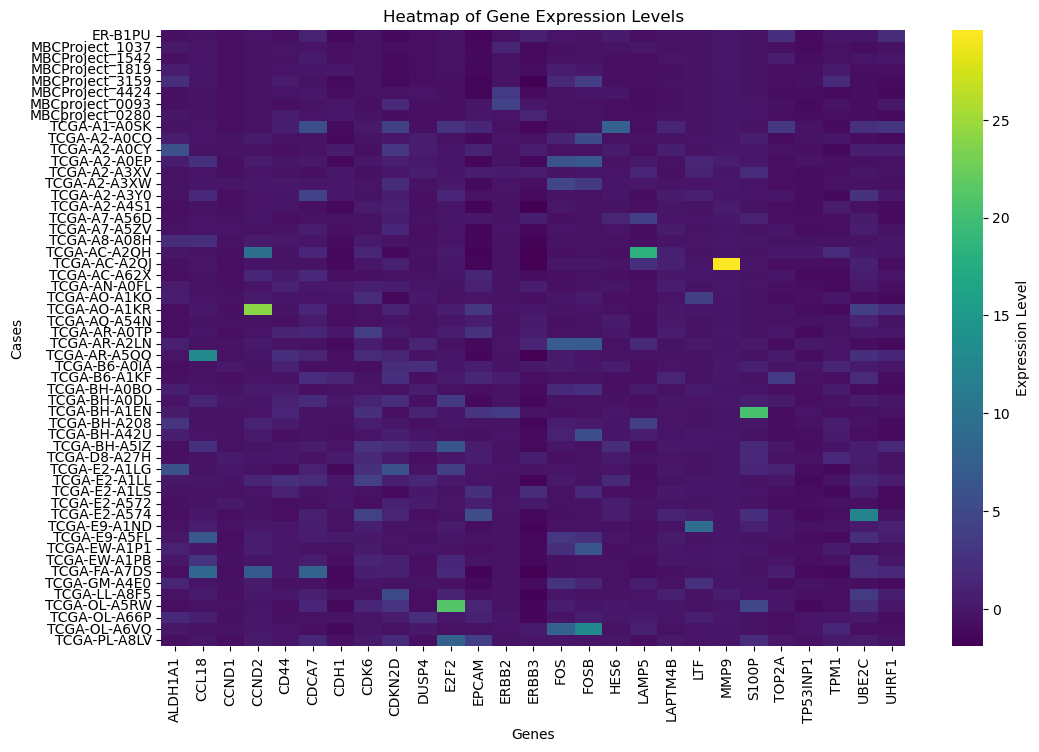

In [871]:
# Use seaborn for a static heatmap as an alternative
plt.figure(figsize=(12, 8))
sns.heatmap(
    unique_expression,
    cmap="viridis",
    cbar_kws={'label': 'Expression Level'},
    xticklabels=True,
    yticklabels=True
)

plt.title("Heatmap of Gene Expression Levels")
plt.xlabel("Genes")
plt.ylabel("Cases")
plt.show()


In [872]:
unique_expression.reset_index(inplace=True)
unique_expression_melted = unique_expression.melt(id_vars='Case', var_name='Gene', value_name='Expression')

In [873]:
unique_expression

Gene,Case,ALDH1A1,CCL18,CCND1,CCND2,CD44,CDCA7,CDH1,CDK6,CDKN2D,...,LAMP5,LAPTM4B,LTF,MMP9,S100P,TOP2A,TP53INP1,TPM1,UBE2C,UHRF1
0,ER-B1PU,-0.556694,-0.356675,-0.763204,-0.251979,-0.626669,1.155525,-1.174175,-0.350390,-1.067234,...,-0.636519,-0.326771,-0.356534,-0.021479,-0.410743,2.222416,-0.927297,-0.145894,-0.156355,1.928875
1,MBCProject_1037,0.085681,-0.279071,-0.732608,-0.357292,-0.284867,-0.297845,-0.609058,-0.455501,-0.648591,...,-0.037018,-0.485902,-0.351890,-0.047205,-0.365459,-0.634904,-0.941030,-0.537339,-0.810348,-0.522617
2,MBCProject_1542,-0.622712,-0.221353,-0.690194,-0.382814,-0.344290,0.222044,-0.610158,-0.437828,-0.984855,...,-0.757539,-0.286934,-0.350581,-0.033377,-0.365293,0.558514,-0.857304,-0.494239,-0.283856,-0.049851
3,MBCProject_1819,0.497091,-0.160954,-0.756312,-0.368544,-0.190670,-0.117806,0.116226,-0.426598,-1.034450,...,-0.693546,-0.564103,-0.359377,-0.041989,-0.410799,-0.565831,-0.615659,0.265471,-0.716404,-0.757944
4,MBCProject_3159,2.174520,-0.080355,-0.751744,-0.366401,0.362479,-0.402128,-1.104226,-0.421133,-1.086505,...,-0.687543,-0.538500,-0.363047,-0.073182,-0.410201,-0.714392,-0.486774,1.856874,-0.824842,-0.963964
5,MBCProject_4424,-0.669947,-0.370250,-0.676076,-0.406065,-0.219610,0.025782,-0.841552,-0.497942,-0.459574,...,-0.860093,-0.578835,-0.342747,-0.126173,-0.320468,-0.865081,-0.850620,-1.025424,-0.906974,-1.064976
6,MBCproject_0093,-0.656642,-0.370250,-0.673764,-0.419031,-0.695418,-0.399251,0.018222,-0.584829,1.751196,...,-0.860093,-0.577969,-0.334694,-0.129493,-0.214122,-0.451817,-0.959259,-0.409976,-0.893252,0.120831
7,MBCproject_0280,-0.171109,-0.329288,-0.727767,-0.361578,0.565011,-0.209629,0.008791,-0.403986,-0.873741,...,-0.784502,-0.537510,-0.323591,-0.071150,-0.259534,-0.702016,-0.808342,-0.703833,-0.815670,-0.923033
8,TCGA-A1-A0SK,-0.336850,-0.279861,-0.752857,-0.357374,0.688513,5.432797,-0.919341,0.175442,4.217729,...,-0.730724,1.207932,-0.363632,-0.102841,-0.406204,3.115723,-0.412141,-0.932278,2.526082,3.005164
9,TCGA-A2-A0CO,0.484706,-0.212295,-0.389814,0.297237,-0.310820,-0.399251,-1.131170,-0.342544,0.054551,...,-0.436512,-0.369111,-0.227950,-0.084965,0.752795,-0.814210,-0.385502,-0.169801,-0.823708,-1.010230


In [875]:


# Map the 'Cancer Stage' values from reshaped_df to unique_expression
unique_expression['Cancer Stage'] = unique_expression['Case'].map(
    reshaped_df_drop.drop_duplicates(subset='Case').set_index('Case')['Cancer Stage']
)

# Display the updated unique_expression DataFrame
print(unique_expression.head())


Gene             Case   ALDH1A1     CCL18     CCND1     CCND2      CD44  \
0             ER-B1PU -0.556694 -0.356675 -0.763204 -0.251979 -0.626669   
1     MBCProject_1037  0.085681 -0.279071 -0.732608 -0.357292 -0.284867   
2     MBCProject_1542 -0.622712 -0.221353 -0.690194 -0.382814 -0.344290   
3     MBCProject_1819  0.497091 -0.160954 -0.756312 -0.368544 -0.190670   
4     MBCProject_3159  2.174520 -0.080355 -0.751744 -0.366401  0.362479   

Gene     CDCA7      CDH1      CDK6    CDKN2D  ...   LAPTM4B       LTF  \
0     1.155525 -1.174175 -0.350390 -1.067234  ... -0.326771 -0.356534   
1    -0.297845 -0.609058 -0.455501 -0.648591  ... -0.485902 -0.351890   
2     0.222044 -0.610158 -0.437828 -0.984855  ... -0.286934 -0.350581   
3    -0.117806  0.116226 -0.426598 -1.034450  ... -0.564103 -0.359377   
4    -0.402128 -1.104226 -0.421133 -1.086505  ... -0.538500 -0.363047   

Gene      MMP9     S100P     TOP2A  TP53INP1      TPM1     UBE2C     UHRF1  \
0    -0.021479 -0.410743  2.2224

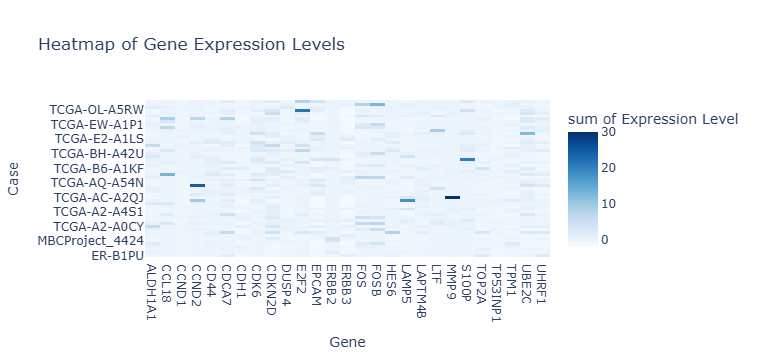

In [877]:
heatmap = px.density_heatmap(
    unique_expression_melted,
    x="Gene",
    y="Case",
    z="Expression",
    color_continuous_scale="Blues",
    range_color=(-2, 30),
    title="Heatmap of Gene Expression Levels",
    labels={'Expression': 'Expression Level'}
)

heatmap.show()

# heatmap_file_path = 'heatmap.html'
# heatmap.write_html(heatmap_file_path)

In [881]:
# Add 'Cancer Stage' to unique_expression_melted
unique_expression_melted = unique_expression_melted.merge(
    reshaped_df_drop[['Case', 'Cancer Stage']].drop_duplicates(),
    on='Case',
    how='left'
)

unique_expression_melted
# # Create the heatmap with 'Cancer Stage' in the tooltip
# heatmap = px.density_heatmap(
#     unique_expression_melted,
#     x="Gene",
#     y="Case",
#     z="Expression",
#     color_continuous_scale="Blues",
#     range_color=(-2, 30),
#     title="Heatmap of Gene Expression Levels",
#     labels={'Expression': 'Expression Level'},
#     hover_data={'Cancer Stage': True}  # Include 'Cancer Stage' in the tooltip
# )

# # Display the heatmap
# heatmap.show()


,Case,Gene,Expression,Cancer Stage
0,ER-B1PU,ALDH1A1,-0.556694,Stage IV
1,MBCProject_1037,ALDH1A1,0.085681,None
2,MBCProject_1542,ALDH1A1,-0.622712,None
3,MBCProject_1819,ALDH1A1,0.497091,None
4,MBCProject_3159,ALDH1A1,2.174520,None
...,...,...,...,...
1453,TCGA-LL-A8F5,UHRF1,0.698090,Stage II
1454,TCGA-OL-A5RW,UHRF1,0.009509,Stage II
1455,TCGA-OL-A66P,UHRF1,-0.797869,Stage II
1456,TCGA-OL-A6VQ,UHRF1,-0.714255,Stage II


C:\Users\sarah\AppData\Local\Temp\ipykernel_22684\2691499403.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



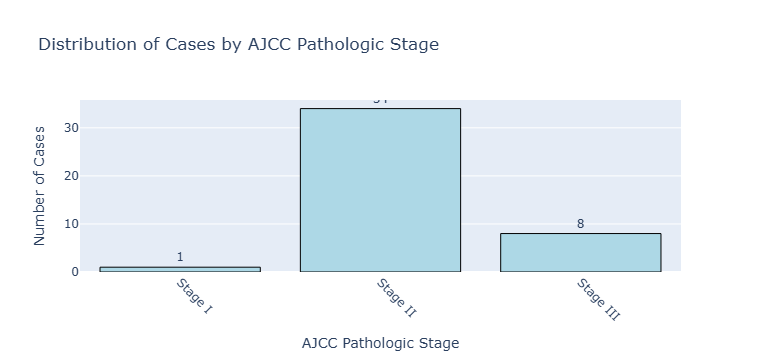

In [883]:
# Filter out "Unknown" values for AJCC columns
aggregated_data = reshaped_df_drop.groupby(
    ['Case', 'Cancer Stage', 'ajcc_pathologic_n', 'ajcc_pathologic_m', 'ajcc_pathologic_t'], as_index=False
).agg({'Expression': 'mean'})

filtered_data = aggregated_data[reshaped_df_drop['ajcc_pathologic_stage'] != "Unknown"]

sorted_stages = ['Stage I', 'Stage II', 'Stage III']
filtered_data['Cancer Stage'] = pd.Categorical(filtered_data['Cancer Stage'], categories=sorted_stages, ordered=True)

# Count cases by stage
stage_counts = filtered_data['Cancer Stage'].value_counts().sort_index()

# Create a DataFrame for Plotly
plot_data = stage_counts.reset_index()
plot_data.columns = ['Cancer Stage', 'Number of Cases']

fig = px.bar(
    plot_data,
    x='Cancer Stage',
    y='Number of Cases',
    text='Number of Cases',
    title='Distribution of Cases by AJCC Pathologic Stage',
    labels={'Cancer Stage': 'AJCC Pathologic Stage', 'Number of Cases': 'Number of Cases'},
)

fig.update_traces(textposition='outside', marker_color='lightblue', marker_line_color='black', marker_line_width=1)
fig.update_layout(xaxis_title='AJCC Pathologic Stage', yaxis_title='Number of Cases', xaxis_tickangle=45)

fig.show()



C:\Users\sarah\AppData\Local\Temp\ipykernel_22684\2925578990.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



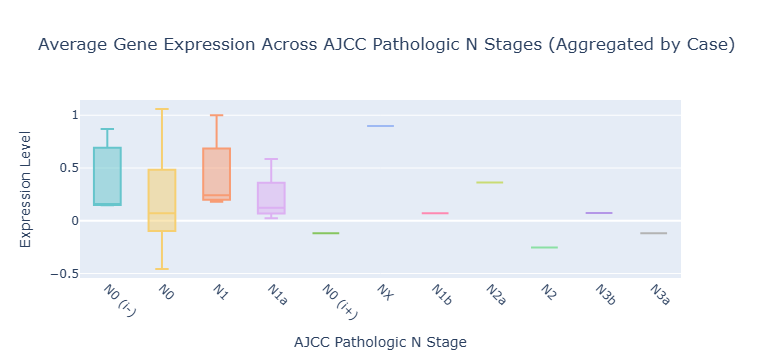

In [887]:
# Filter out "Unknown" values for AJCC Pathologic N stages
filtered_data_state_n = aggregated_data[reshaped_df_drop['ajcc_pathologic_n'] != "Unknown"]

fig = px.box(
    filtered_data_state_n,
    x='ajcc_pathologic_n',
    y='Expression',
    color='ajcc_pathologic_n',  # Optional: Assign a unique color to each category
    title="Average Gene Expression Across AJCC Pathologic N Stages (Aggregated by Case)",
    labels={
        'ajcc_pathologic_n': 'AJCC Pathologic N Stage',
        'Expression': 'Expression Level'
    },
    color_discrete_sequence=px.colors.qualitative.Pastel 
)

fig.update_layout(
    xaxis_title="AJCC Pathologic N Stage",
    yaxis_title="Expression Level",
    xaxis_tickangle=45,
    showlegend=False  
)


fig.show()


C:\Users\sarah\AppData\Local\Temp\ipykernel_22684\4276000563.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



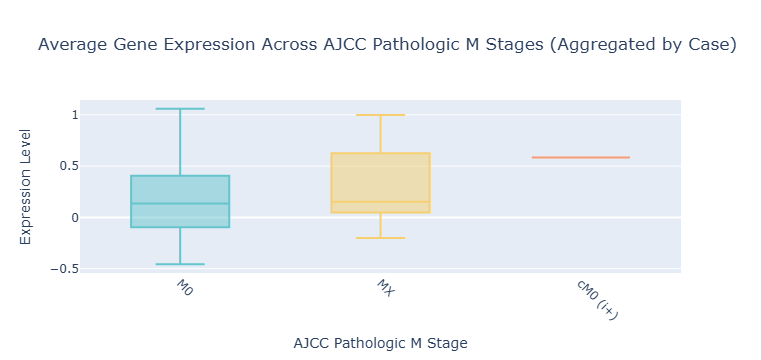

In [889]:
# Filter out "Unknown" values for AJCC Pathologic M stages
filtered_data_state_m = aggregated_data[reshaped_df_drop['ajcc_pathologic_m'] != "Unknown"]

fig = px.box(
    filtered_data_state_m,
    x='ajcc_pathologic_m',
    y='Expression',
    color='ajcc_pathologic_m', 
    title="Average Gene Expression Across AJCC Pathologic M Stages (Aggregated by Case)",
    labels={
        'ajcc_pathologic_m': 'AJCC Pathologic M Stage',
        'Expression': 'Expression Level'
    },
    color_discrete_sequence=px.colors.qualitative.Pastel 
)


fig.update_layout(
    xaxis_title="AJCC Pathologic M Stage",
    yaxis_title="Expression Level",
    xaxis_tickangle=45,
    showlegend=False  # Hide legend if not needed
)

# Show the interactive plot
fig.show()


C:\Users\sarah\AppData\Local\Temp\ipykernel_22684\3230661905.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



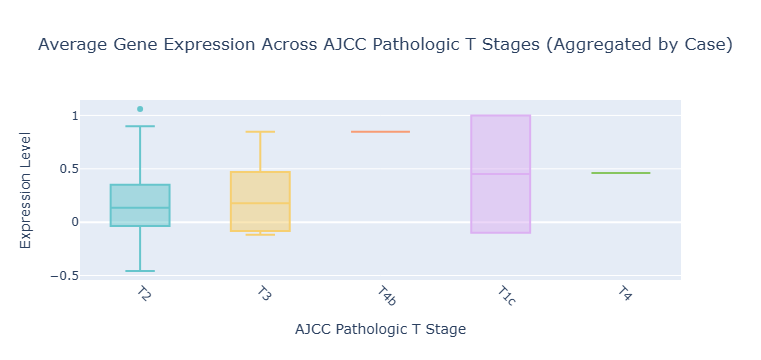

In [891]:
# Filter out "Unknown" values for AJCC Pathologic T stages
filtered_data_state_t = aggregated_data[reshaped_df_drop['ajcc_pathologic_t'] != "Unknown"]

fig = px.box(
    filtered_data_state_t,
    x='ajcc_pathologic_t',
    y='Expression',
    color='ajcc_pathologic_t',  
    title="Average Gene Expression Across AJCC Pathologic T Stages (Aggregated by Case)",
    labels={
        'ajcc_pathologic_t': 'AJCC Pathologic T Stage',
        'Expression': 'Expression Level'
    },
    color_discrete_sequence=px.colors.qualitative.Pastel 
)


fig.update_layout(
    xaxis_title="AJCC Pathologic T Stage",
    yaxis_title="Expression Level",
    xaxis_tickangle=45,
    showlegend=False 
)

fig.show()


C:\Users\sarah\AppData\Local\Temp\ipykernel_22684\1542023494.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



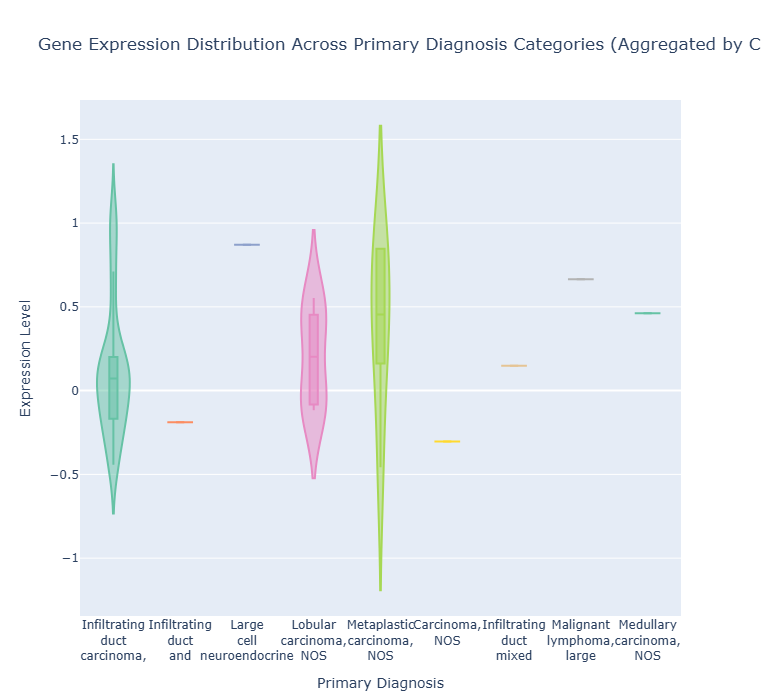

In [893]:
# Aggregate data by case (mean expression for cases with multiple rows)
aggregated_data = reshaped_df_drop.groupby(['Case', 'primary_diagnosis'], as_index=False).agg({'Expression': 'mean'})

# Remove "Not Reported" values from the primary diagnosis column
filtered_data = aggregated_data[aggregated_data['primary_diagnosis'] != "Not Reported"]

# Shorten or format long labels with line breaks
filtered_data['primary_diagnosis'] = filtered_data['primary_diagnosis'].apply(
    lambda x: '<br>'.join(x.split(' ', 3)[:3]) if len(x.split(' ')) > 3 else x.replace(' ', '<br>')
)

# Create a violin plot using Plotly
fig = px.violin(
    filtered_data,
    x='primary_diagnosis',
    y='Expression',
    box=True,  
    points=False,
    color='primary_diagnosis',  
    title="Gene Expression Distribution Across Primary Diagnosis Categories (Aggregated by Case)",
    labels={
        'primary_diagnosis': 'Primary Diagnosis',
        'Expression': 'Expression Level'
    },
    color_discrete_sequence=px.colors.qualitative.Set2 
)


fig.update_layout(
    xaxis_title="Primary Diagnosis",
    yaxis_title="Expression Level",
    xaxis_tickangle=0,  
    showlegend=False,  
    width=1200, 
    height=700  
)


fig.show()

